In [ ]:

!pip install datasets

In [1]:
from huggingface_hub import HfApi, hf_hub_url
from torchvision import models, transforms
from PIL import Image
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

/home/cslee/anaconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

dataset = load_dataset("keremberke/shoe-classification",'full')


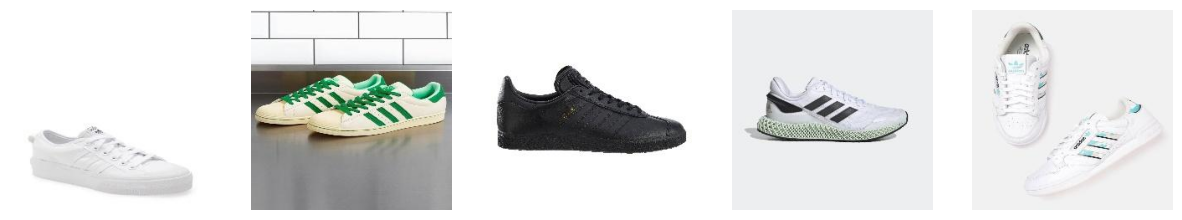

In [58]:
# 이미지 5개 출력
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = dataset["train"][i]["image"]
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

show_images(dataset)


In [4]:

def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0)

In [5]:
# pretrained=True: 이미지넷 데이터로 사전학습된 가중치를 가져오기
model = models.alexnet(pretrained=True) 
model.eval() # 모델을 eval모드로 사용


/home/cslee/anaconda3/envs/llm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cslee/anaconda3/envs/llm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
# 마지막 레이어를 representation으로 사용
def get_embedding(image, model):
    # 모델의 가중치 업데이트 중지
    with torch.no_grad():
        return model(preprocess_image(image)).numpy().flatten()

In [9]:
# Identity()를 쓰면 input벡터가 나옴
# torch.nn.Identify(): 입력과 동일한 tensor를 출력으로 내보내주는 layer
# model의 출력을 4096->1000이 아닌 4096->4096으로 변경
model.classifier[6] = torch.nn.Identity() 
embeddings = [get_embedding(dataset["train"][i]["image"], model) for i in range(len(dataset["train"]))]

In [15]:
# 마지막 레이어의 input벡터인 4096차원이 나옴
embeddings[0].shape

(4096,)

In [30]:
# 4096차원에 대해 6개 클러스터로 구분
nn_model = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
nn_model.fit(embeddings)

NearestNeighbors(algorithm='ball_tree', n_neighbors=6)

In [45]:
# 유사이미지 검색
def retrieve_images(index, nn_model, dataset):
    index = int(index)
    
    # 최근접 이웃 6개 가져오기
    # indices: 본인점, 가까운점5개
    # distances: 본인점거리0, 가까운점 5개까지의 거리
    distances, indices = nn_model.kneighbors([embeddings[index]])

    indexed_distances = [(int(i), dist) for i, dist in zip(indices[0], distances[0]) if i != index]
    
    indexed_distances.sort(key=lambda x: x[1]) # 낮은 거리 순으로 정렬

    retrieved_images = [dataset["train"][idx]["image"] for idx, _ in indexed_distances]
    return retrieved_images

In [ ]:
len(embeddings) # 576개 이미지

576

In [33]:
embeddings[0].shape # 이미지 1개당 4096차원

(4096,)

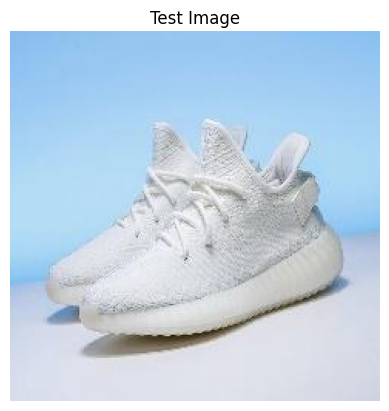

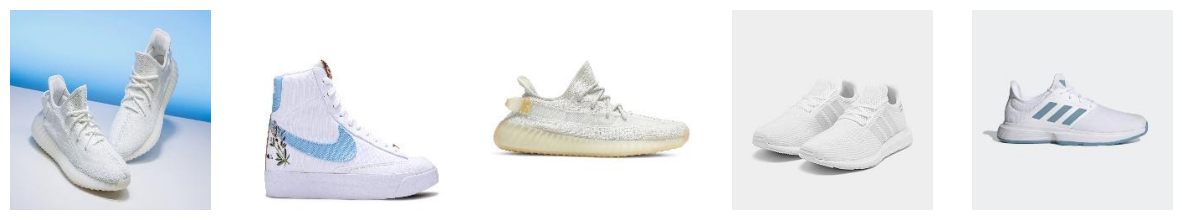

In [49]:
test_index= 94
retrieved_images = retrieve_images(test_index, nn_model, dataset)

plt.imshow(dataset["train"][test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

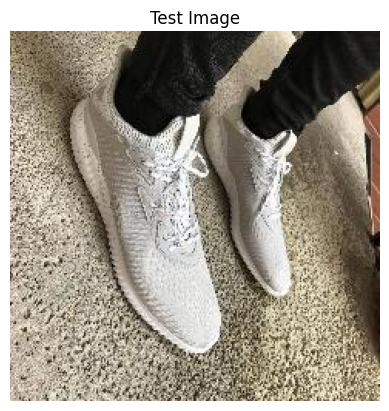

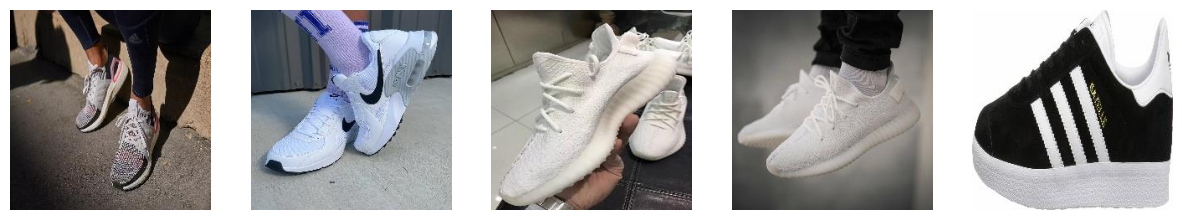

In [20]:
test_index= 65
retrieved_images = retrieve_images(test_index, nn_model, dataset)

plt.imshow(dataset["train"][test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

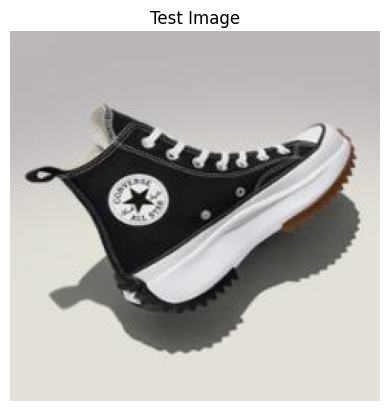

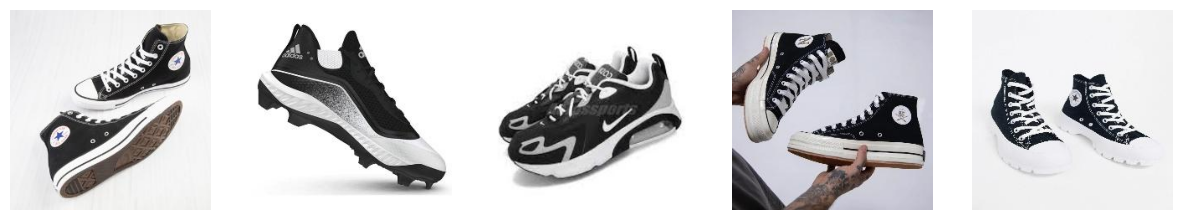

In [21]:
test_index= 358
retrieved_images = retrieve_images(test_index, nn_model, dataset)
plt.imshow(dataset["train"][test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

# Deeper model

In [63]:
def get_embedding(image, model):
    with torch.no_grad():
        output = model(preprocess_image(image))
        return output.cpu().numpy().flatten()

In [64]:
# resnet152 구조 가져옴
model2 = models.resnet152(pretrained=True)
model2.eval()


/home/cslee/anaconda3/envs/llm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cslee/anaconda3/envs/llm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/cslee/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|█████████████████████████████████████████████████████████████████████████████████| 230M/230M [04:23<00:00, 915kB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [65]:
# 마지막 레이어의 출력을 2048 -> 2048
model2.fc = torch.nn.Identity()
embeddings2 = [get_embedding(dataset["train"][i]["image"], model2) for i in range(len(dataset["train"]))]

In [66]:
nn_model2 = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
nn_model2.fit(embeddings2)

NearestNeighbors(algorithm='ball_tree', n_neighbors=6)

In [72]:
len(embeddings2)

576

In [74]:
embeddings2[0].shape

(2048,)

In [67]:

def retrieve_images2(index, nn_model, dataset):
    index = int(index)

    distances, indices = nn_model.kneighbors([embeddings2[index]])

    indexed_distances = [(int(i), dist) for i, dist in zip(indices[0], distances[0]) if i != index]

    indexed_distances.sort(key=lambda x: x[1])

    retrieved_images = [dataset["train"][idx]["image"] for idx, _ in indexed_distances]
    return retrieved_images

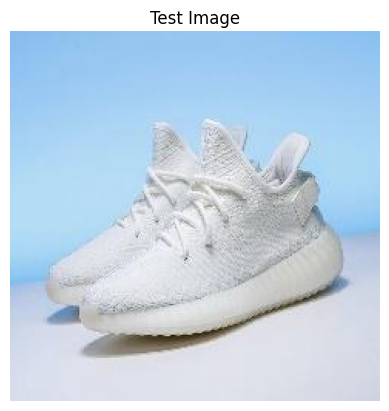

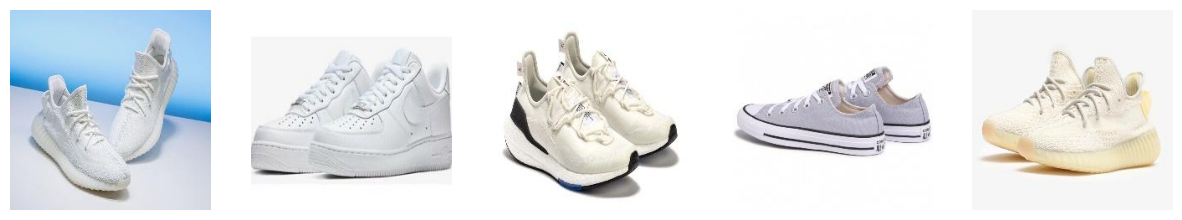

In [68]:
test_index= 94
retrieved_images = retrieve_images2(test_index, nn_model2, dataset)
plt.imshow(dataset["train"][test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

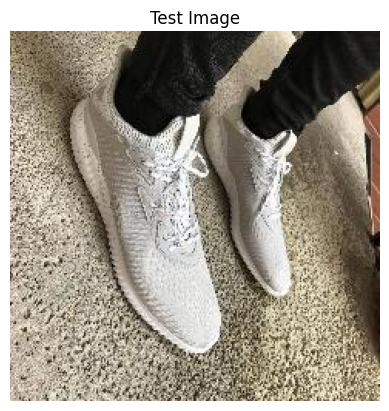

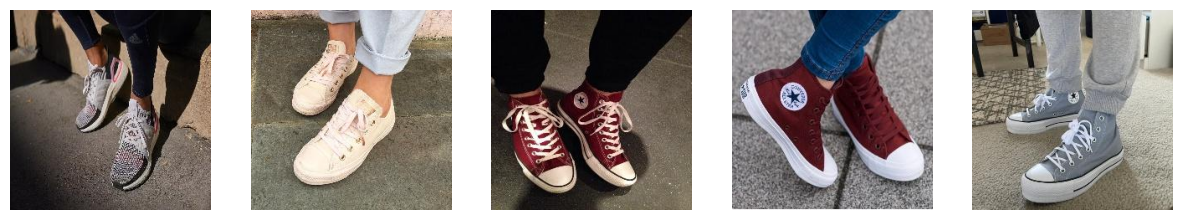

In [69]:
test_index= 65
retrieved_images = retrieve_images2(test_index, nn_model2, dataset)
plt.imshow(dataset["train"][test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

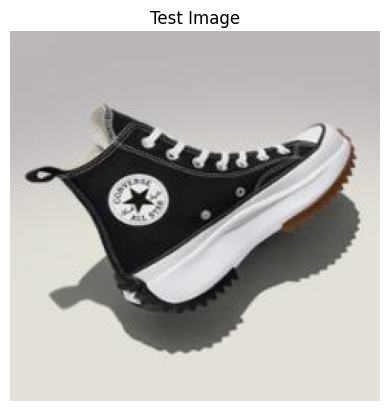

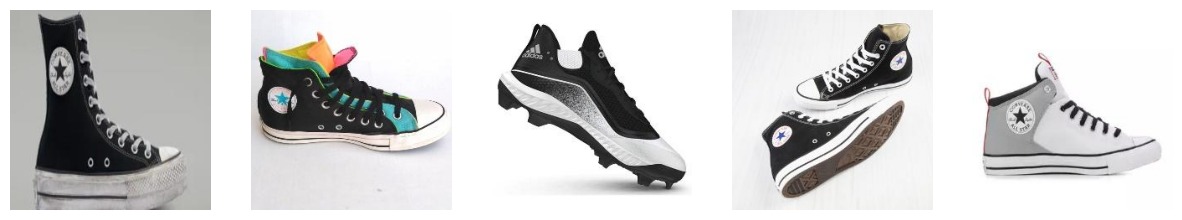

In [70]:
test_index= 358
retrieved_images = retrieve_images2(test_index, nn_model2, dataset)
plt.imshow(dataset["train"][test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})